Predictive Filter Flow for Non-Uniform Motion Blur Removal
================
**Author**: `Shu Kong <https://www.ics.uci.edu/~skong2/pff.html>`

**Date**: Nov. 2018

A demo jupyter script for demonstrating how to train, evaluate, and visualize the model. It squeezes the following parts.

-  defining model architecture
-  defining the loss function
-  training protocal
-  evaluation protocal
-  analysis using PCA, k-means and t-SNE.


Others: 
- Pytorch is used for this work.
- Please manually install packages as shown below if necessary

import packages
------------------

In [5]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle

import math
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets, models, transforms

from libs_deblur.utils.metrics import *
from libs_deblur.utils.flow_functions import *
from libs_deblur.models.pixel_embedding_model import *
from libs_deblur.datasetMotionBlur import *
from libs_deblur.trainvalGaussBlur import *
import libs_deblur.pyblur
import warnings # ignore warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'LineDictionary'

 setup config parameters
 -----------------

In [2]:
# set device, which gpu to use.
device ='cpu'
if torch.cuda.is_available(): device='cuda:0'

################## set attributes for this project/experiment ##################
# config result folder
exp_dir = './exp'
project_name = 'main004_MotionBlur_v0_Ksz17Res18softmax'

#pretrainedModelPath = '../tutorial_pytorch_03_instSegm/exp/main004_instFromSemantic_v4_ftV3_largeLR/epoch-200.paramOnly'  


# config data loader    
#path_to_root = '../data/BSR/BSDS500/data/images'
#path_to_root = '../data/PollenGrain24way'
#path_to_root = '../data/JPEG_compression'
#path_to_root = '../data/GaussBlurDataset'
#path_to_root = '../data/MotionBlurDataset'
path_to_root = '/home/skong2/scratch/dataset/MotionBlurDataset'


batch_size = 8
gradLossWeight = 1.

embedding_dim = 16 # dimension of the learned embedding space
kernel_size = 17
cropSize = [64, 64]
# Gaussian blur kernel
sigmaMin=0.5
sigmaMax=2

lambda_norm = 0.1
total_epoch_num = 500 # total number of epoch in training
base_lr = 0.0005 # base learning rate

torch.cuda.device_count()
torch.cuda.empty_cache()

save_dir = os.path.join(exp_dir, project_name)
print(save_dir)    
if not os.path.exists(save_dir): os.makedirs(save_dir)
log_filename = os.path.join(save_dir, 'train.log')

./exp/main004_MotionBlur_v0_Ksz17Res18softmax


define model architecture
---------

In [3]:
class SiamesePixelEmbed(nn.Module):
    def __init__(self, emb_dimension=64, filterSize=11, device='cpu', pretrained=False):
        super(SiamesePixelEmbed, self).__init__()
        self.device = device
        self.emb_dimension = emb_dimension  
        self.PEMbase = PixelEmbedModelResNet18(emb_dimension=self.emb_dimension, pretrained=pretrained)  
        self.rawEmbFeature1 = 0
        self.rawEmbFeature2 = 0        
        self.embFeature1_to_2 = 0
        self.embFeature1_to_2 = 0
        self.filterSize = filterSize
        self.filterSize2Channel = self.filterSize**2
                
        self.ordered_embedding = nn.Sequential(            
            nn.Conv2d(self.emb_dimension, self.filterSize2Channel, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(self.filterSize2Channel),     
            nn.Conv2d(self.filterSize2Channel, self.filterSize2Channel, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(self.filterSize2Channel),            
            nn.Conv2d(self.filterSize2Channel, self.filterSize2Channel, kernel_size=3, padding=1, bias=True)
        )
        
        
    def forward(self, inputs1, inputs2):        
        self.rawEmbFeature1 = self.PEMbase.forward(inputs1)
        #self.rawEmbFeature2 = self.PEMbase.forward(inputs2)
        
        #img1_to_img2 = torch.cat([self.rawEmbFeature1, self.rawEmbFeature2], 1)
        #img2_to_img1 = torch.cat([self.rawEmbFeature2, self.rawEmbFeature1], 1)
        
        self.embFeature1_to_2 = self.ordered_embedding(self.rawEmbFeature1)        
        self.embFeature1_to_2 = F.softmax(self.embFeature1_to_2, 1)
        
        #self.embFeature2_to_1 = self.ordered_embedding(img2_to_img1)
        #self.embFeature2_to_1 = F.softmax(self.embFeature2_to_1, 1)
        
        return self.embFeature1_to_2    #self.embFeature2_to_1, self.embFeature1_to_2    

define loss function
---------

In [4]:
class LossOrderedPairReconstruction(nn.Module):
    def __init__(self, device='cpu', filterSize=11):
        super(LossOrderedPairReconstruction, self).__init__()
        self.device = device
        self.filterSize = filterSize        
        self.filterSize2Channel = self.filterSize**2
        self.reconstructImage = 0
        
    def forward(self, image1, image2, filters_img1_to_img2):
        N,C,H,W = image1.size()
        self.reconstructImage = self.rgbImageFilterFlow(image1, filters_img1_to_img2)
        diff = self.reconstructImage - image2               
        diff = torch.abs(diff)       
        totloss = torch.sum(torch.sum(torch.sum(torch.sum(diff))))        
        return totloss/(N*C*H*W)
    
    
    def rgbImageFilterFlow(self, img, filters):                
        inputChannelSize = 1
        outputChannelSize = 1
        N = img.size(0)
        paddingFunc = nn.ZeroPad2d(int(self.filterSize/2))
        img = paddingFunc(img)        
        imgSize = [img.size(2),img.size(3)]
        
        out_R = F.unfold(img[:,0,:,:].unsqueeze(1), (self.filterSize, self.filterSize))
        out_R = out_R.view(N, out_R.size(1), imgSize[0]-self.filterSize+1, imgSize[1]-self.filterSize+1)    
        #out_R = paddingFunc(out_R)
        out_R = torch.mul(out_R, filters)
        out_R = torch.sum(out_R, dim=1).unsqueeze(1)

        out_G = F.unfold(img[:,1,:,:].unsqueeze(1), (self.filterSize, self.filterSize))
        out_G = out_G.view(N, out_G.size(1), imgSize[0]-self.filterSize+1, imgSize[1]-self.filterSize+1)    
        #out_G = paddingFunc(out_G)
        out_G = torch.mul(out_G, filters)
        out_G = torch.sum(out_G, dim=1).unsqueeze(1)

        out_B = F.unfold(img[:,2,:,:].unsqueeze(1), (self.filterSize, self.filterSize))
        out_B = out_B.view(N, out_B.size(1), imgSize[0]-self.filterSize+1, imgSize[1]-self.filterSize+1)    
        #out_B = paddingFunc(out_B)
        out_B = torch.mul(out_B, filters)
        out_B = torch.sum(out_B, dim=1).unsqueeze(1)
        return torch.cat([out_R, out_G, out_B], 1)

evaluation/testing demo
-----------
##### load a pretrained model

In [5]:
#eval_model(curmodel, dataloaders, dataset_sizes, criterion, device=device)
loss_ImageReconst = LossOrderedPairReconstruction(device=device, filterSize=kernel_size)


################## load model ###################
#path_to_save_paramOnly = os.path.join(save_dir,'bestValModel.paramOnly')
path_to_save_paramOnly = os.path.join(save_dir,'epoch-143.paramOnly')
path_to_save_paramOnly = os.path.join(save_dir,'epoch-167.paramOnly')
path_to_save_paramOnly = os.path.join(save_dir,'epoch-235.paramOnly')
path_to_save_paramOnly = os.path.join(save_dir,'epoch-353.paramOnly')
path_to_save_paramOnly = os.path.join(save_dir,'epoch-445.paramOnly')


print(path_to_save_paramOnly)
curmodel = SiamesePixelEmbed(emb_dimension=embedding_dim, 
                                    filterSize=kernel_size,
                                    device=device, pretrained=False)
curmodel.load_state_dict(torch.load(path_to_save_paramOnly))
curmodel.to(device);    
#print(curmodel.state_dict)
curmodel.eval()
#curmodel.train()
#curmodel.training = False
print(curmodel.training)

./exp/main004_MotionBlur_v0_Ksz17Res18softmax/epoch-445.paramOnly
False


In [6]:
################## evaluate over validation set ###################
transform4Image = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((127.,127.,127.),(127.,127.,127.)) # (mean, std)
    ]) # (mean, std)


# moderateBlurDataset  severeBlurDataset severeBlurDataset_fullRes moderateBlurDataset_fullRes
subset = 'moderateBlurDataset' 
valset = Dataset4MotionBlur(root_dir=path_to_root, size=[64,64], # 64x64
                            set_name=subset, transform=transform4Image,
                            sigmaMin=sigmaMin, sigmaMax=sigmaMax,
                            downsampleFactor=1)

valdataloader = DataLoader(valset, batch_size=1,shuffle=False, num_workers=1) # num_work can be set to batch_size
print(len(valset))

objDemoShowFlow = DemoShowFlow()

80


Full resolution testing
================

In [7]:
# moderateBlurDataset  severeBlurDataset severeBlurDataset_fullRes moderateBlurDataset_fullRes
subset = 'moderateBlurDataset_fullRes' 
valset = Dataset4MotionBlur__Evaluation(root_dir=path_to_root, size=[-64,-64], # 64x64
                                        set_name=subset, transform=transform4Image,
                                        sigmaMin=sigmaMin, sigmaMax=sigmaMax,
                                        downsampleFactor=1)

valdataloader = DataLoader(valset, batch_size=1,shuffle=False, num_workers=1) # num_work can be set to batch_size

_, tmp = os.path.split(path_to_save_paramOnly)
tmp, _ = tmp.split('.')
result_dir = './result'
save_dir = os.path.join(result_dir, project_name+'_'+tmp, subset)
if not os.path.exists(save_dir): os.makedirs(save_dir)
print(save_dir)  

XXX = []

patchSize = 64
patchStride = 20
patchBnd2rm = 20
globalBnd2rm = 20
list_PSNR, list_SSIM, list_PSNR_LR, list_SSIM_LR = [], [], [], []
list_PSNR_fullRes, list_SSIM_fullRes, list_PSNR_LR_fullRes, list_SSIM_LR_fullRes = [],[],[],[]
sampleId = 0
id_of_interest = -3 # 4 13 17

for sample in iter(valdataloader):  
    sampleId += 1    
    if sampleId!=id_of_interest and id_of_interest>=0: continue
        
    kernel, imgNoisyFullRes, imgFullRes, blurImage, clearImage = sample
    blurImage = Variable(blurImage, volatile=True).to(device)
    #imgList2 = Variable(imgList2, volatile=True).to(device)
    
    NCHW = blurImage.size()
    reconstructedHR = np.zeros((NCHW[2],NCHW[3],NCHW[1]),dtype=np.float32)
    countMap = np.zeros((NCHW[2],NCHW[3],1),dtype=np.float32)
    filterFlowMap = np.zeros((NCHW[0], kernel_size*kernel_size, NCHW[2], NCHW[3]),dtype=np.float32) 
        
    start_h, start_w, countPatch = 0, 0, 0
    stopFlagH = 0
    while stopFlagH==0: # start_h+patchSize < imgList1.size(2):
        if start_h+patchSize>=blurImage.size(2): 
            start_h=blurImage.size(2)-patchSize
            stopFlagH = 1

        stopFlagW = 0
        start_w = 0
        while stopFlagW==0: # start_w+patchSize <= imgList1.size(3): 
            if start_w+patchSize>=blurImage.size(3): 
                start_w=blurImage.size(3)-patchSize
                stopFlagW = 1

            #print(start_h, start_h+patchSize,start_w,start_w+patchSize)
            countPatch += 1
            filterFlow = curmodel(blurImage[:,:,start_h:start_h+patchSize,start_w:start_w+patchSize], 0)
            _ = loss_ImageReconst(blurImage[:,:,start_h:start_h+patchSize,start_w:start_w+patchSize], 0, filterFlow)
            reconsturctedImage2 = loss_ImageReconst.reconstructImage

            countMap[start_h+patchBnd2rm:start_h+patchSize-patchBnd2rm,
                     start_w+patchBnd2rm:start_w+patchSize-patchBnd2rm, :]+=1
            
            
            if patchBnd2rm>0:
                reconsturctedImage2 = reconsturctedImage2[:,:,patchBnd2rm:-patchBnd2rm,
                                                          patchBnd2rm:-patchBnd2rm]
                filterFlow = filterFlow[:,:,patchBnd2rm:-patchBnd2rm,
                                        patchBnd2rm:-patchBnd2rm]
            
            
            reconsturctedImage2 = reconsturctedImage2.detach().cpu().numpy().squeeze().transpose((1,2,0))               
            reconstructedHR[start_h+patchBnd2rm:start_h+patchSize-patchBnd2rm,
                            start_w+patchBnd2rm:start_w+patchSize-patchBnd2rm, :] += reconsturctedImage2
            
            filterFlow = filterFlow.detach().cpu().numpy()
            filterFlowMap[:,:,start_h+patchBnd2rm:start_h+patchSize-patchBnd2rm,
                          start_w+patchBnd2rm:start_w+patchSize-patchBnd2rm] += filterFlow

            start_w += patchStride    
            if start_w==blurImage.size(3): break            
        start_h += patchStride

        
    blurImage = blurImage.cpu().numpy().squeeze().transpose((1,2,0))   
    clearImage = clearImage.cpu().numpy().squeeze().transpose((1,2,0))
    
    if globalBnd2rm>0:
        blurImage = blurImage[globalBnd2rm:-globalBnd2rm,globalBnd2rm:-globalBnd2rm,:]
        clearImage = clearImage[globalBnd2rm:-globalBnd2rm,globalBnd2rm:-globalBnd2rm,:]
        reconstructedHR = reconstructedHR[globalBnd2rm:-globalBnd2rm,globalBnd2rm:-globalBnd2rm,:]
        countMap = countMap[globalBnd2rm:-globalBnd2rm,globalBnd2rm:-globalBnd2rm,:]
        filterFlowMap = filterFlowMap[0,:,globalBnd2rm:-globalBnd2rm,globalBnd2rm:-globalBnd2rm]
        
        #imgNoisyFullRes = imgNoisyFullRes[0,:,globalBnd2rm:-globalBnd2rm,globalBnd2rm:-globalBnd2rm]
        #imgFullRes = imgFullRes[0,:,globalBnd2rm:-globalBnd2rm,globalBnd2rm:-globalBnd2rm]
        #reconstructedHR_fullRes = reconstructedHR_fullRes[globalBnd2rm:-globalBnd2rm,globalBnd2rm:-globalBnd2rm,:]
        
    reconstructedHR = np.divide(reconstructedHR,countMap)    
    countMap = np.expand_dims(countMap.squeeze(),0)
    filterFlowMap = np.divide(filterFlowMap,countMap)
    

    imgNoisyFullRes, imgFullRes = imgNoisyFullRes.detach().cpu().numpy(), imgFullRes.detach().cpu().numpy() 
    imgNoisyFullRes = imgNoisyFullRes.squeeze()
    imgFullRes = imgFullRes.squeeze()
    if globalBnd2rm>0:
        imgNoisyFullRes = imgNoisyFullRes[globalBnd2rm:-globalBnd2rm,globalBnd2rm:-globalBnd2rm,:]
        imgFullRes = imgFullRes[globalBnd2rm:-globalBnd2rm,globalBnd2rm:-globalBnd2rm,:]
    

    reconstructedHR_fullRes = reconstructedHR
    reconstructedHR_fullRes = misc.imresize(reconstructedHR_fullRes, (imgFullRes.shape[0],imgFullRes.shape[1]), 'bicubic')

    
    flowVisShow=torch.from_numpy(filterFlowMap)
    UV = objDemoShowFlow.filterFlow2UV(flowVisShow).detach().numpy()
    UV = UV/np.ceil(kernel_size/2)    
    flowVisShow = objDemoShowFlow.computeColor(UV[0], UV[1])    
    misc.imsave(os.path.join(save_dir, '{:02d}_filterflow.png'.format(sampleId)), flowVisShow, format='png')
    misc.imsave(os.path.join(save_dir, '{:02d}_deblurHR.png'.format(sampleId)), reconstructedHR_fullRes, format='png')
    misc.imsave(os.path.join(save_dir, '{:02d}_blurred.png'.format(sampleId)), imgNoisyFullRes, format='png')
    misc.imsave(os.path.join(save_dir, '{:02d}_clearImage.png'.format(sampleId)), (clearImage.clip(-1,1)+1)/2*255., format='png')
    
    XXX+=[filterFlowMap]
    
    imgFullResY = rgb2ycbcr(imgFullRes.astype(np.int))
    imgFullResY = imgFullResY[:,:,0]
    imgNoisyFullResY = rgb2ycbcr(imgNoisyFullRes.astype(np.int))
    imgNoisyFullResY = imgNoisyFullResY[:,:,0]
    reconstructedHR_fullResY = rgb2ycbcr(reconstructedHR_fullRes.astype(np.int)) 
    reconstructedHR_fullResY = reconstructedHR_fullResY[:,:,0]

    tmp = psnr(reconstructedHR_fullResY, imgFullResY, 255)    
    list_PSNR_fullRes += [tmp]    
    tmp = ssim(reconstructedHR_fullResY, imgFullResY, data_range=imgFullResY.max()-imgFullResY.min())    
    list_SSIM_fullRes += [tmp]
    tmp = psnr(imgNoisyFullResY, imgFullResY, 255)    
    list_PSNR_LR_fullRes += [tmp]
    tmp = ssim(imgNoisyFullResY, imgFullResY, data_range=imgFullResY.max()-imgFullResY.min())       
    list_SSIM_LR_fullRes += [tmp]
        

    clearImageY = rgb2ycbcr(((clearImage+1)/2*255).astype(np.int))
    clearImageY = clearImageY[:,:,0]
    blurImageY = rgb2ycbcr(((blurImage+1)/2*255).astype(np.int))
    blurImageY = blurImageY[:,:,0]
    reconImageY = rgb2ycbcr(((reconstructedHR+1)/2*255).astype(np.int)) 
    reconImageY = reconImageY[:,:,0]

    tmp = psnr(reconImageY, clearImageY, 255)    
    list_PSNR += [tmp]    
    tmp = ssim(reconImageY, clearImageY, data_range=clearImageY.max()-clearImageY.min())    
    list_SSIM += [tmp]
    tmp = psnr(blurImageY, clearImageY, 255)    
    list_PSNR_LR += [tmp]
    tmp = ssim(blurImageY, clearImageY, data_range=clearImageY.max()-clearImageY.min())       
    list_SSIM_LR += [tmp]
    
    if sampleId%1==0: 
        print('\n{:03d} PSNR:{:.3f}, SSMI:{:.3f} -- blur PSNR:{:.3f}, SSMI:{:.3f}'.format(
            sampleId, list_PSNR[-1], list_SSIM[-1], list_PSNR_LR[-1], list_SSIM_LR[-1], ))
        print('\tfullRes PSNR:{:.3f}, SSMI:{:.3f} -- blur PSNR:{:.3f}, SSMI:{:.3f}'.format(
            list_PSNR_fullRes[-1], list_SSIM_fullRes[-1], list_PSNR_LR_fullRes[-1], list_SSIM_LR_fullRes[-1], ))
    if sampleId>=id_of_interest>=0: break
      
        
        
nplist_PSNR = np.asarray(list_PSNR)
nplist_SSIM = np.asarray(list_SSIM)
nplist_PSNR_LR = np.asarray(list_PSNR_LR)
nplist_SSIM_LR = np.asarray(list_SSIM_LR)
print('\n\nsummary of reslt -- execut-version\nPSNR:{:.3f} std:{:.3f}'.format(nplist_PSNR.mean(), nplist_PSNR.std()))
print('SSIM:{:.3f}, std:{:.3f}'.format(nplist_SSIM.mean(), nplist_SSIM.std())) 
print('\nlow-res\nPSNR:{:.3f} std:{:.3f}'.format(nplist_PSNR_LR.mean(), nplist_PSNR_LR.std()))
print('SSIM:{:.3f}, std:{:.3f}\n\n\n'.format(nplist_SSIM_LR.mean(), nplist_SSIM_LR.std()))  

nplist_PSNR_fullRes = np.asarray(list_PSNR_fullRes)
nplist_SSIM_fullRes = np.asarray(list_SSIM_fullRes)
nplist_PSNR_LR_fullRes = np.asarray(list_PSNR_LR_fullRes)
nplist_SSIM_LR_fullRes = np.asarray(list_SSIM_LR_fullRes)
print('summary of reslt -- fullRes-version\nPSNR:{:.3f} std:{:.3f}'.format(nplist_PSNR_fullRes.mean(), nplist_PSNR_fullRes.std()))
print('SSIM:{:.3f}, std:{:.3f}'.format(nplist_SSIM_fullRes.mean(), nplist_SSIM_fullRes.std())) 
print('\nlow-res\nPSNR:{:.3f} std:{:.3f}'.format(nplist_PSNR_LR_fullRes.mean(), nplist_PSNR_LR_fullRes.std()))
print('SSIM:{:.3f}, std:{:.3f}\n\n\n'.format(nplist_SSIM_LR_fullRes.mean(), nplist_SSIM_LR_fullRes.std())) 

./result/main004_MotionBlur_v0_Ksz17Res18softmax_epoch-445/moderateBlurDataset_fullRes

001 PSNR:23.487, SSMI:0.754 -- blur PSNR:22.214, SSMI:0.667
	fullRes PSNR:23.491, SSMI:0.754 -- blur PSNR:22.221, SSMI:0.667


summary of reslt -- execut-version
PSNR:23.487 std:0.000
SSIM:0.754, std:0.000

low-res
PSNR:22.214 std:0.000
SSIM:0.667, std:0.000



summary of reslt -- fullRes-version
PSNR:23.491 std:0.000
SSIM:0.754, std:0.000

low-res
PSNR:22.221 std:0.000
SSIM:0.667, std:0.000





Text(0.5,1,'filter flow')

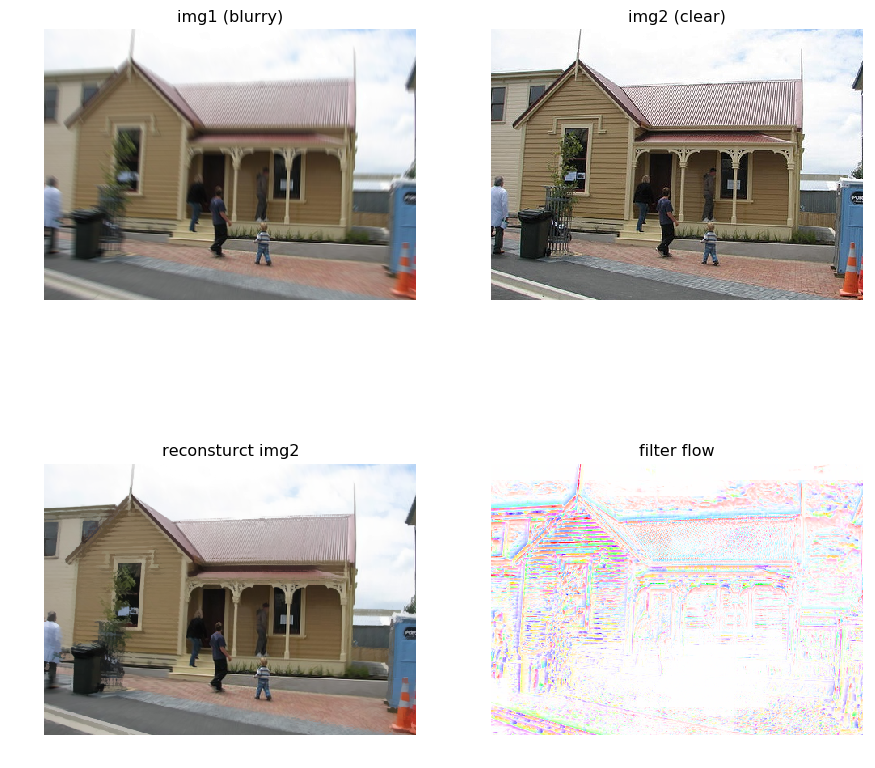

In [8]:
objDemoShowFlow = DemoShowFlow()

figWinNumHeight, figWinNumWidth = 2, 2
plt.figure(figsize=(11,11), dpi=96, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1 
plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1     
plt.imshow((blurImage.clip(-1,1)+1)/2)
plt.axis('off')
plt.title('img1 (blurry)')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1    
plt.imshow((clearImage.clip(-1,1)+1)/2)
plt.axis('off')
plt.title('img2 (clear)')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1       
plt.imshow((reconstructedHR.clip(-1,1)+1)/2)
plt.axis('off')
plt.title('reconsturct img2')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
flowVisShow=torch.from_numpy(filterFlowMap)
UV = objDemoShowFlow.filterFlow2UV(flowVisShow).detach().numpy()
UV = UV/np.ceil(kernel_size/2)
#UV = UV/UV.max()
flowVisShow = objDemoShowFlow.computeColor(UV[0], UV[1])/255.    
plt.imshow(flowVisShow) # torch.from_numpy(flowVis)
plt.axis('off')
plt.title('filter flow')

#misc.imsave('deblur_filterflow.png', flowVisShow*255, format='png')

(289, 3082000)


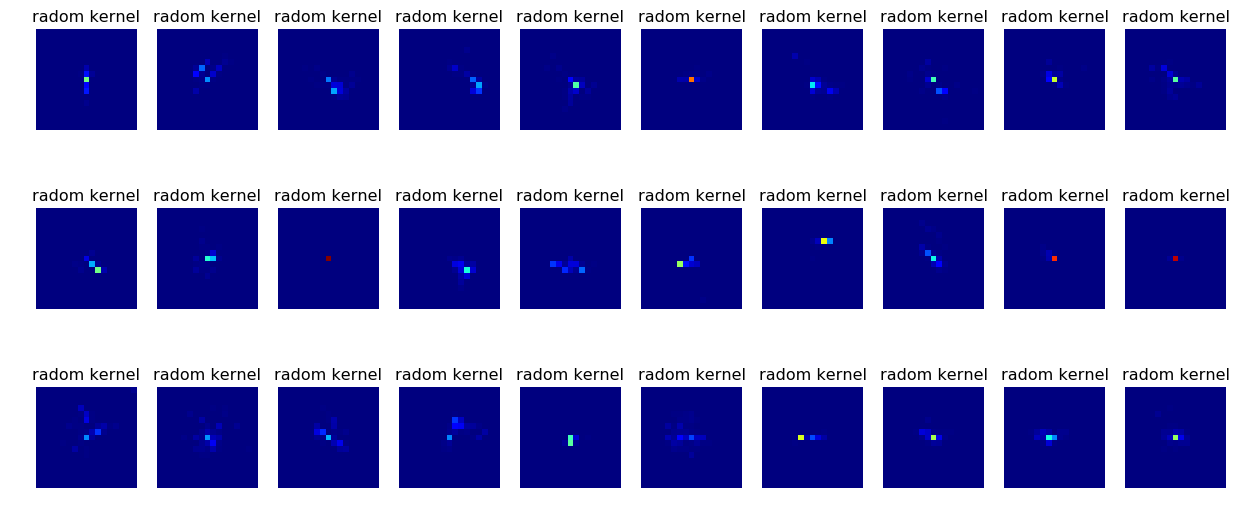

In [10]:
from sklearn.decomposition import PCA
import scipy

X = XXX[0]
X = X.reshape((kernel_size**2,-1))
for i in range(1,len(XXX)): # len(XXX)
    tmpX = XXX[i]
    tmpX = tmpX.reshape((kernel_size**2,-1))
    X = np.concatenate((X,tmpX),axis=1)
    
print(X.shape)

figWinNumHeight, figWinNumWidth, subwinCount = 3, 10, 1
plt.figure(figsize=(16,7), dpi=96, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()


caxisMin, caxisMax = X.min(), X.max()
for i in range(figWinNumHeight*figWinNumWidth):
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    
    idx = random.randint(0, X.shape[1])
    tmpKernel = X[:,idx]
    #tmpKernel = tmpKernel-tmpKernel.min()
    #tmpKernel = tmpKernel/max(tmpKernel.max(),0.00001)
    tmpKernel = tmpKernel.reshape((kernel_size,kernel_size))
    plt.imshow(tmpKernel, cmap='jet')    
    plt.clim(caxisMin, caxisMax)
    plt.axis('off')
    plt.title('radom kernel')

In [11]:
#UV = UV/np.ceil(kernel_size/2)
print(UV.shape)
print(filterFlowMap.shape)
print(UV.reshape(2,-1).transpose().shape)
print(filterFlowMap.reshape(kernel_size**2,-1).transpose().shape)
print(filterFlowMap.reshape(kernel_size**2,-1).transpose().reshape(-1,kernel_size,kernel_size).shape)

(2, 335, 460)
(289, 335, 460)
(154100, 2)
(154100, 289)
(154100, 17, 17)


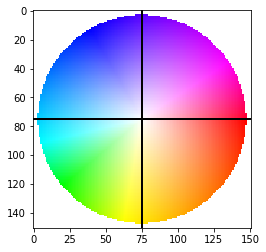

In [12]:
plt.figure()
plt.imshow(objDemoShowFlow.FlowColorChart)
plt.show()

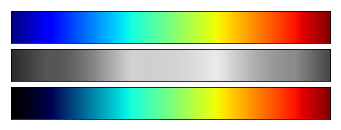

In [9]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
from matplotlib import cm

def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)
    
    
    
def new_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    #fadein = np.linspace(0, 1.0, num=cmap.N)
    fadein = np.linspace(0, 1.0, num=100)
    #colors[:fadein.shape[0],0] *= fadein       
    #colors[:fadein.shape[0],1] *= fadein       
    colors[:fadein.shape[0],2] *= fadein       
    return LinearSegmentedColormap.from_list(cmap.name + "_new", colors, cmap.N)
    
        
    
def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    cmap_gray = grayscale_cmap(cmap)
    grayscale = cmap_gray(np.arange(cmap_gray.N))
    
    cmap_new = new_cmap(cmap)
    cmap_new = cmap_new(np.arange(cmap_new.N))
    
    fig, ax = plt.subplots(3, figsize=(6, 2),
                           subplot_kw=dict(xticks=[], yticks=[]))
    ax[0].imshow([colors], extent=[0, 10, 0, 1])
    ax[1].imshow([grayscale], extent=[0, 10, 0, 1])
    ax[2].imshow([cmap_new], extent=[0, 10, 0, 1])
    
view_colormap('jet')



cmap_jet = plt.cm.get_cmap('jet')
#colors = cmap(np.arange(cmap.N))
jet_fadein = new_cmap(cmap_jet)

In [10]:
import random
a = range(50)
idx = list(range(50))

random.shuffle(idx)
#idx = idx[:10]
print(idx)

[8, 41, 32, 19, 42, 3, 39, 26, 28, 44, 10, 47, 23, 45, 25, 35, 21, 27, 43, 6, 2, 18, 13, 4, 22, 36, 11, 48, 37, 16, 33, 17, 46, 9, 31, 14, 49, 29, 38, 0, 1, 7, 40, 30, 12, 34, 20, 24, 15, 5]


In [11]:
from matplotlib import offsetbox
import matplotlib as mpl
def plot_components(data, coordY, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    caxisMax, caxisMin = images.max(), images.min()
    norm = mpl.colors.Normalize(vmin=caxisMin, vmax=caxisMax)
        
    import random
    idx = list(range(coordY.shape[0]))
    random.shuffle(idx)
    idx = idx[:400]
    
        
    ax.plot(coordY[:, 0], coordY[:, 1], '.w', alpha=0.0)   
    ax.plot(coordY[idx, 0], coordY[idx, 1], '.k', alpha=0.5)    
    if images is not None:
        min_dist_2 = (thumb_frac * max(coordY.max(0) - coordY.min(0))) ** 2
        shown_images = np.array([2 * coordY.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((coordY[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, coordY[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], zoom=1.5, 
                                      cmap=cmap, norm=norm,),
                coordY[i], pad=0.1, frameon=True, bboxprops=dict(edgecolor='white')) # bboxprops=dict(edgecolor='white') 
            ax.add_artist(imagebox)

In [12]:
theta = np.radians(90) # anti-clockwise x-degree
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c,-s), (s, c)))
print(R) 


A =  UV.reshape(2,-1).transpose()
print(type(A), A.shape)
A = np.matmul(A, R)

[[ 6.123234e-17 -1.000000e+00]
 [ 1.000000e+00  6.123234e-17]]
<class 'numpy.ndarray'> (154100, 2)


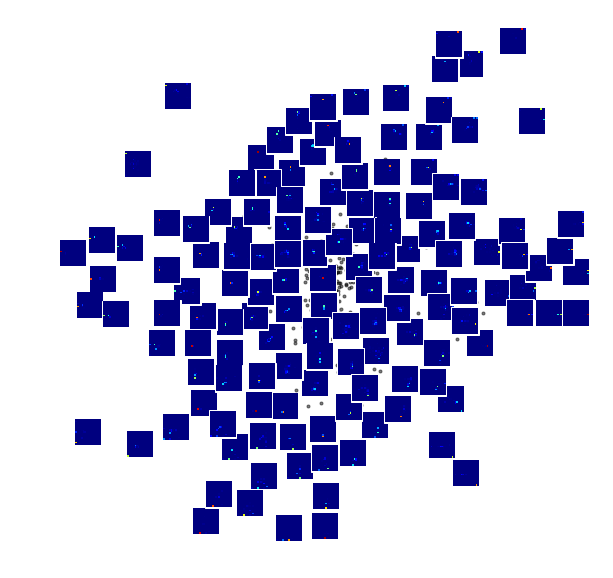

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

# Y = np.flip(Y,axis=1)
plot_components(filterFlowMap.reshape(kernel_size**2,-1).transpose(),
                A, #UV.reshape(2,-1).transpose(),
                images=filterFlowMap.reshape(kernel_size**2,-1).transpose().reshape(-1,kernel_size,kernel_size), 
                thumb_frac=0.05, cmap=cmap_jet)
plt.axis('off')
plt.savefig(path.join(save_dir,'filters_t-sne_centered.png'.format(idx)),bbox_inches='tight',transparent=True)
plt.savefig(path.join(save_dir,'filters_t-sne_centered.eps'.format(idx)),bbox_inches='tight',transparent=True)

(289, 3082000) (289, 3082000)
(289,) (289, 289)


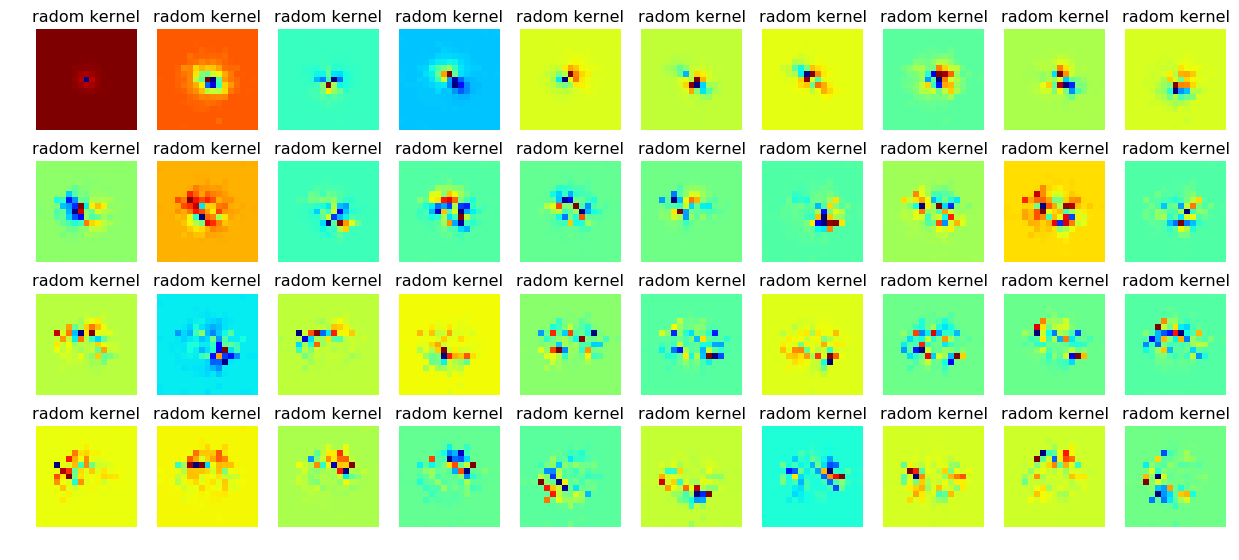

In [13]:
#centered_matrix = X - X.mean(axis=1)[:, np.newaxis]
#centered_matrix = X - (0*X.mean(axis=1)[:, np.newaxis]+1/17.0/17.0)#
centered_matrix = X 
print(X.shape, centered_matrix.shape)

cov = np.dot(centered_matrix, centered_matrix.T)

#eigvals, eigvecs = np.linalg.eig(cov)
eigvals, eigvecs = scipy.linalg.eigh(cov)

idx = eigvals.argsort()[::-1]   
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]
print(eigvals.shape, eigvecs.shape)


figWinNumHeight, figWinNumWidth, subwinCount = 4, 10, 1
plt.figure(figsize=(16,7), dpi=96, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()

for idx in range(figWinNumHeight*figWinNumWidth):
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    
    tmpKernel = eigvecs[:,idx]
    tmpKernel = tmpKernel-tmpKernel.min()
    tmpKernel = tmpKernel/max(tmpKernel.max(),0.00001)
    tmpKernel = tmpKernel.reshape((kernel_size,kernel_size))
    plt.imshow(tmpKernel, cmap='jet')    
    plt.axis('off')
    plt.title('radom kernel')    

In [21]:
a = np.abs(eigvals**2)
b=a[:10].sum()
c=a.sum()
print(type(a),b,c, b/c)

<class 'numpy.ndarray'> 477997500000.0 479683050000.0 0.9964861


(17, 17)


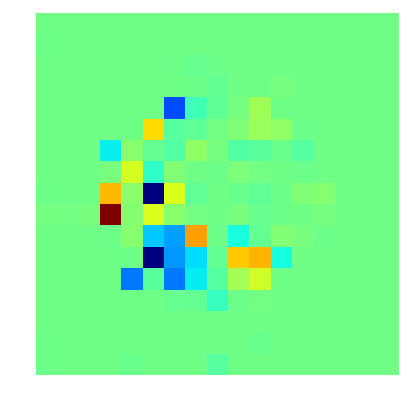

In [14]:
ffmean = X.mean(axis=1)
ffmean = ffmean.reshape((kernel_size,kernel_size))
print(ffmean.shape)

plt.figure(figsize=(5,5), dpi=96, frameon=False) # facecolor='w', edgecolor='k',
plt.imshow(ffmean, cmap='jet')
plt.axis('off')
plt.savefig(path.join(save_dir,'ffmean.png'),bbox_inches='tight',transparent=True)    

for idx in range(figWinNumHeight*figWinNumWidth):    
    tmpKernel = eigvecs[:,idx]
    tmpKernel = tmpKernel-tmpKernel.min()
    tmpKernel = tmpKernel/max(tmpKernel.max(),0.00001)
    tmpKernel = tmpKernel.reshape((kernel_size,kernel_size))
    plt.imshow(tmpKernel, cmap='jet')    
    plt.axis('off')
    #plt.title('radom kernel')    
    plt.savefig(path.join(save_dir,'PC{}.png'.format(idx)),bbox_inches='tight',transparent=True)
        
 

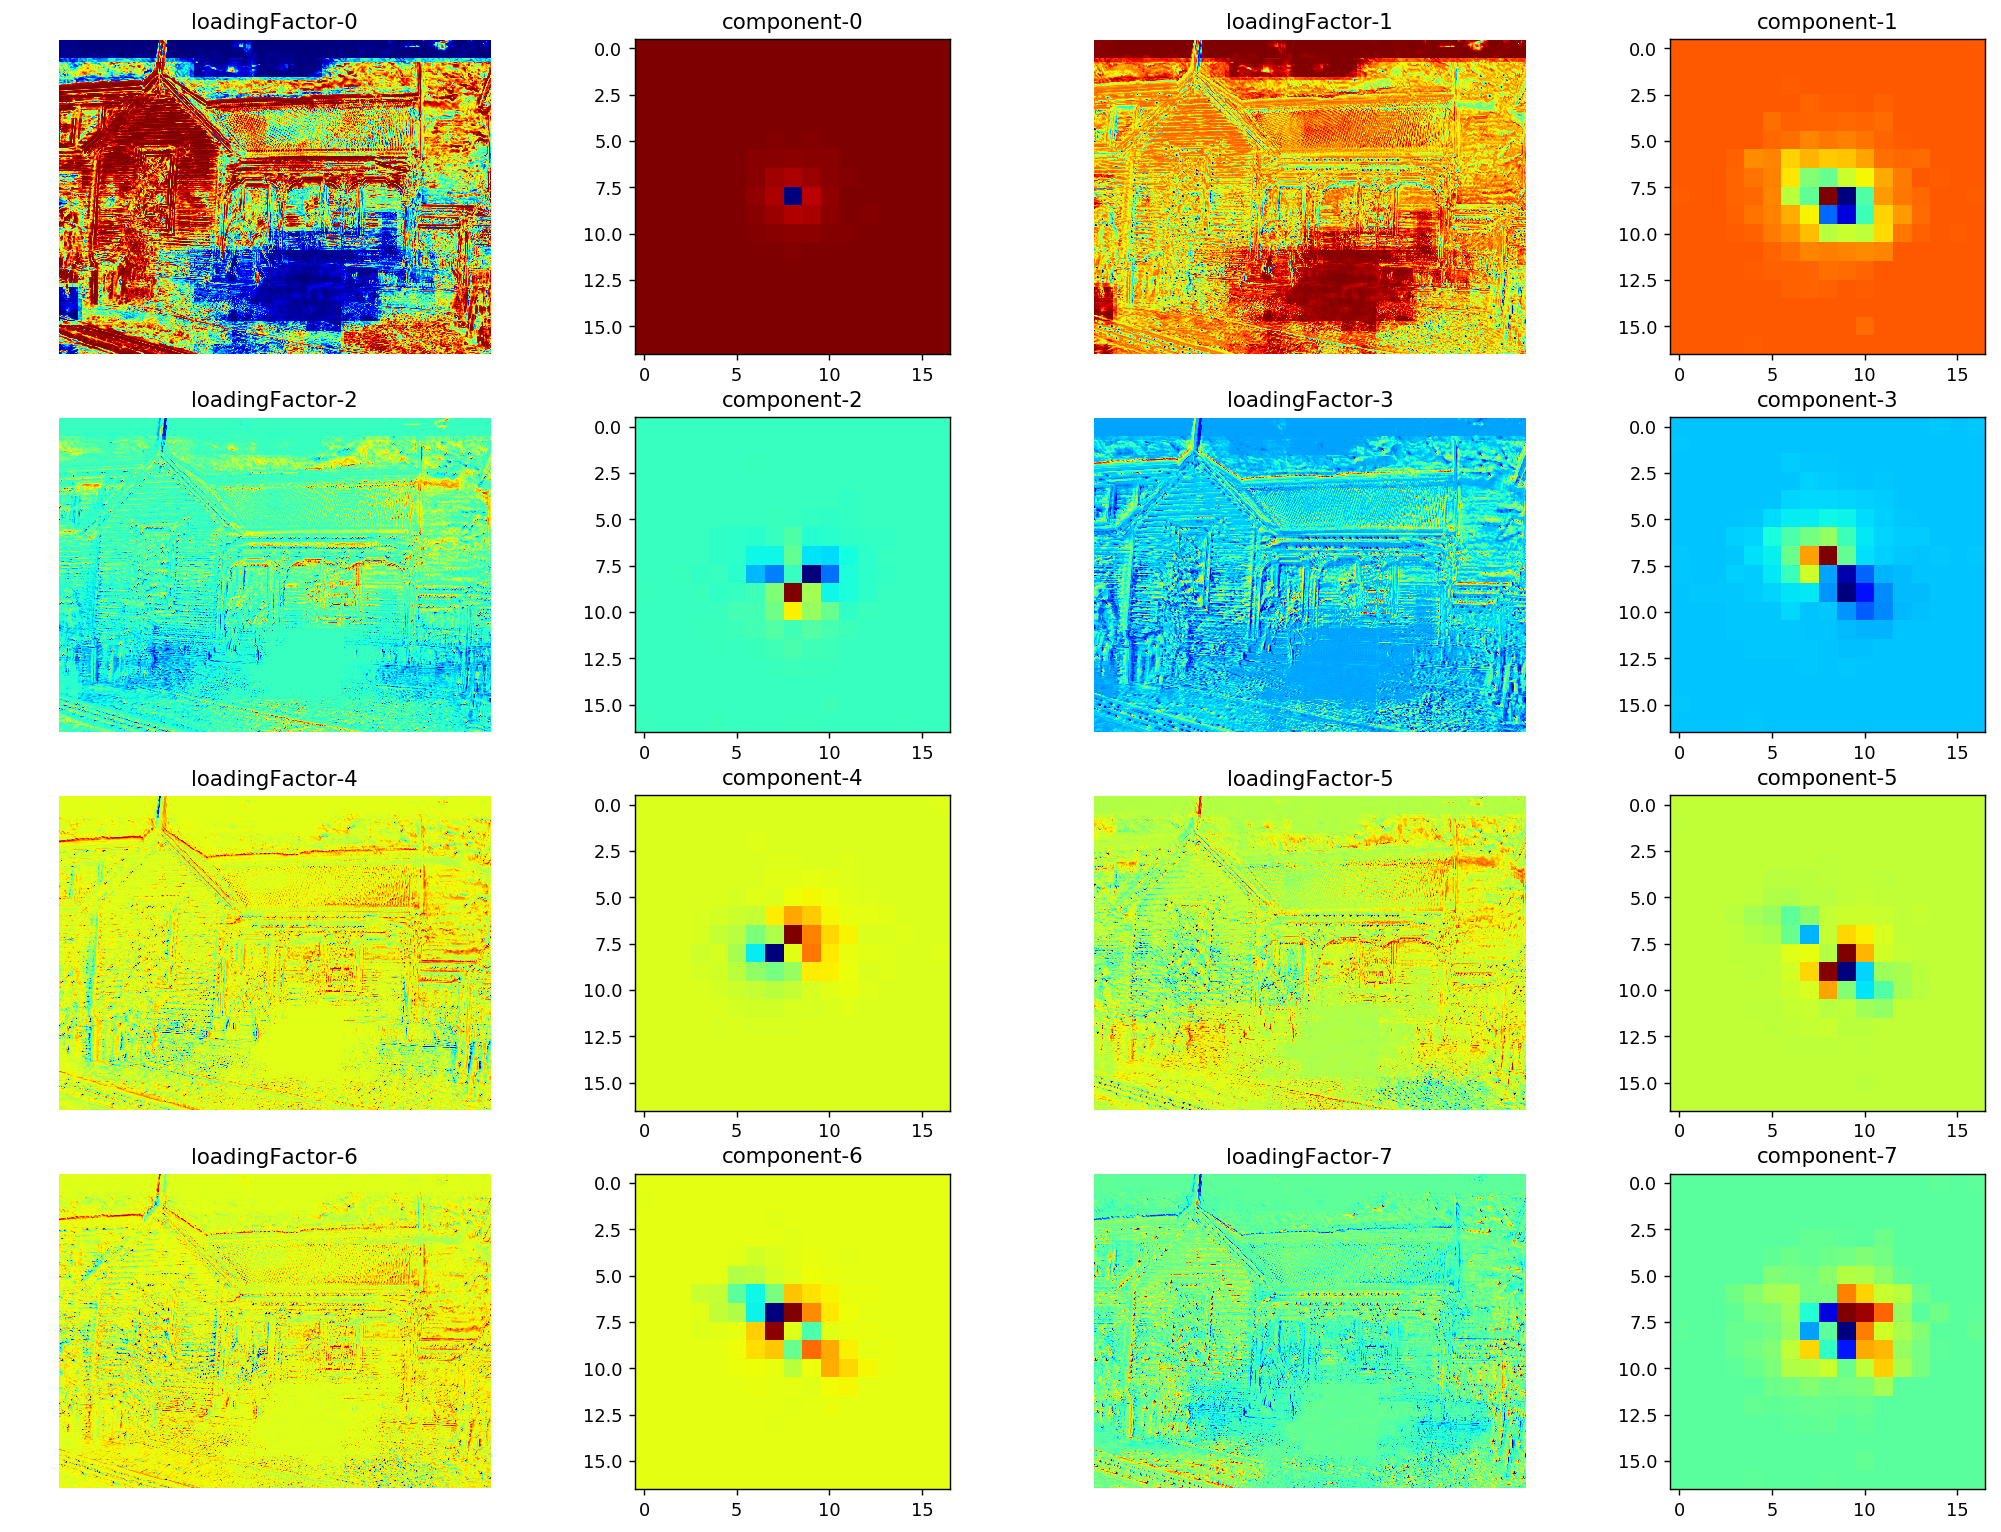

In [15]:
figWinNumHeight, figWinNumWidth, subwinCount = 4, 4, 1
plt.figure(figsize=(20,15), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()

sampleIdx=0
X = XXX[sampleIdx]    
X = X.reshape((kernel_size**2,-1))
centered_matrix = X - X.mean(axis=1)[:, np.newaxis]
for idx in range(int(figWinNumHeight*figWinNumWidth/2)):
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    
    tmpPC = eigvecs[:,idx]
    tmpLoadFactor = np.dot(tmpPC, centered_matrix)
    tmpLoadFactor = tmpLoadFactor.reshape((XXX[sampleIdx].shape[1],XXX[sampleIdx].shape[2]))
    
    plt.imshow(tmpLoadFactor, cmap='jet')    
    plt.axis('off')
    plt.title('loadingFactor-{}'.format(idx))  
    
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    tmpPC = tmpPC.reshape((kernel_size,kernel_size))
    plt.imshow(tmpPC, cmap='jet') 
    plt.title('component-{}'.format(idx))  

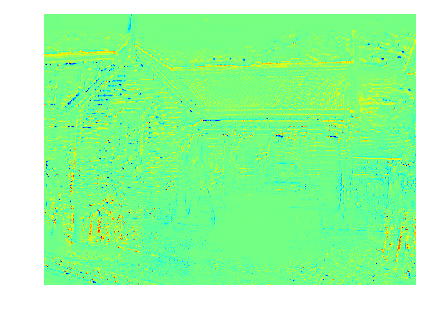

In [16]:
plt.figure(figsize=(5,5), dpi=96, frameon=False) # facecolor='w', edgecolor='k',
X = XXX[sampleIdx]    
Xflat = X.reshape((kernel_size**2,-1))

for idx in range(figWinNumHeight*figWinNumWidth):  
    tmpPC = eigvecs[:,idx]
    tmpLoadFactor = np.dot(tmpPC, Xflat)
    tmpLoadFactor = tmpLoadFactor.reshape((X.shape[1],X.shape[2]))
    plt.imshow(tmpLoadFactor, cmap='jet')     
    plt.axis('off')
    plt.savefig(path.join(save_dir,'LoadingFactor{}.png'.format(idx)),bbox_inches='tight',transparent=True)    

In [17]:
from sklearn.cluster import KMeans
KK = 200

In [ ]:
X = XXX[0]
X = X.reshape((kernel_size**2,-1))
for i in range(1,5): # len(XXX)
    tmpX = XXX[i]
    tmpX = tmpX.reshape((kernel_size**2,-1))
    X = np.concatenate((X,tmpX),axis=1)
    
print(X.shape)

kmeans = KMeans(n_clusters=KK, verbose=1, max_iter=80, tol=0.0001, n_jobs=15)

X = np.transpose(X)
kmeans.fit(X)
print(kmeans.cluster_centers_.shape)

filename = 'kmeans_K{}.sav'.format(KK)
pickle.dump(kmeans, open(filename, 'wb'))

In [18]:
filename = 'kmeans_K{}.sav'.format(KK)
kmeans = pickle.load(open(filename, 'rb'))
kcenters = kmeans.cluster_centers_.reshape((kmeans.cluster_centers_.shape[0],kernel_size,kernel_size))
caxisMax, caxisMin = kcenters.max(), kcenters.min()

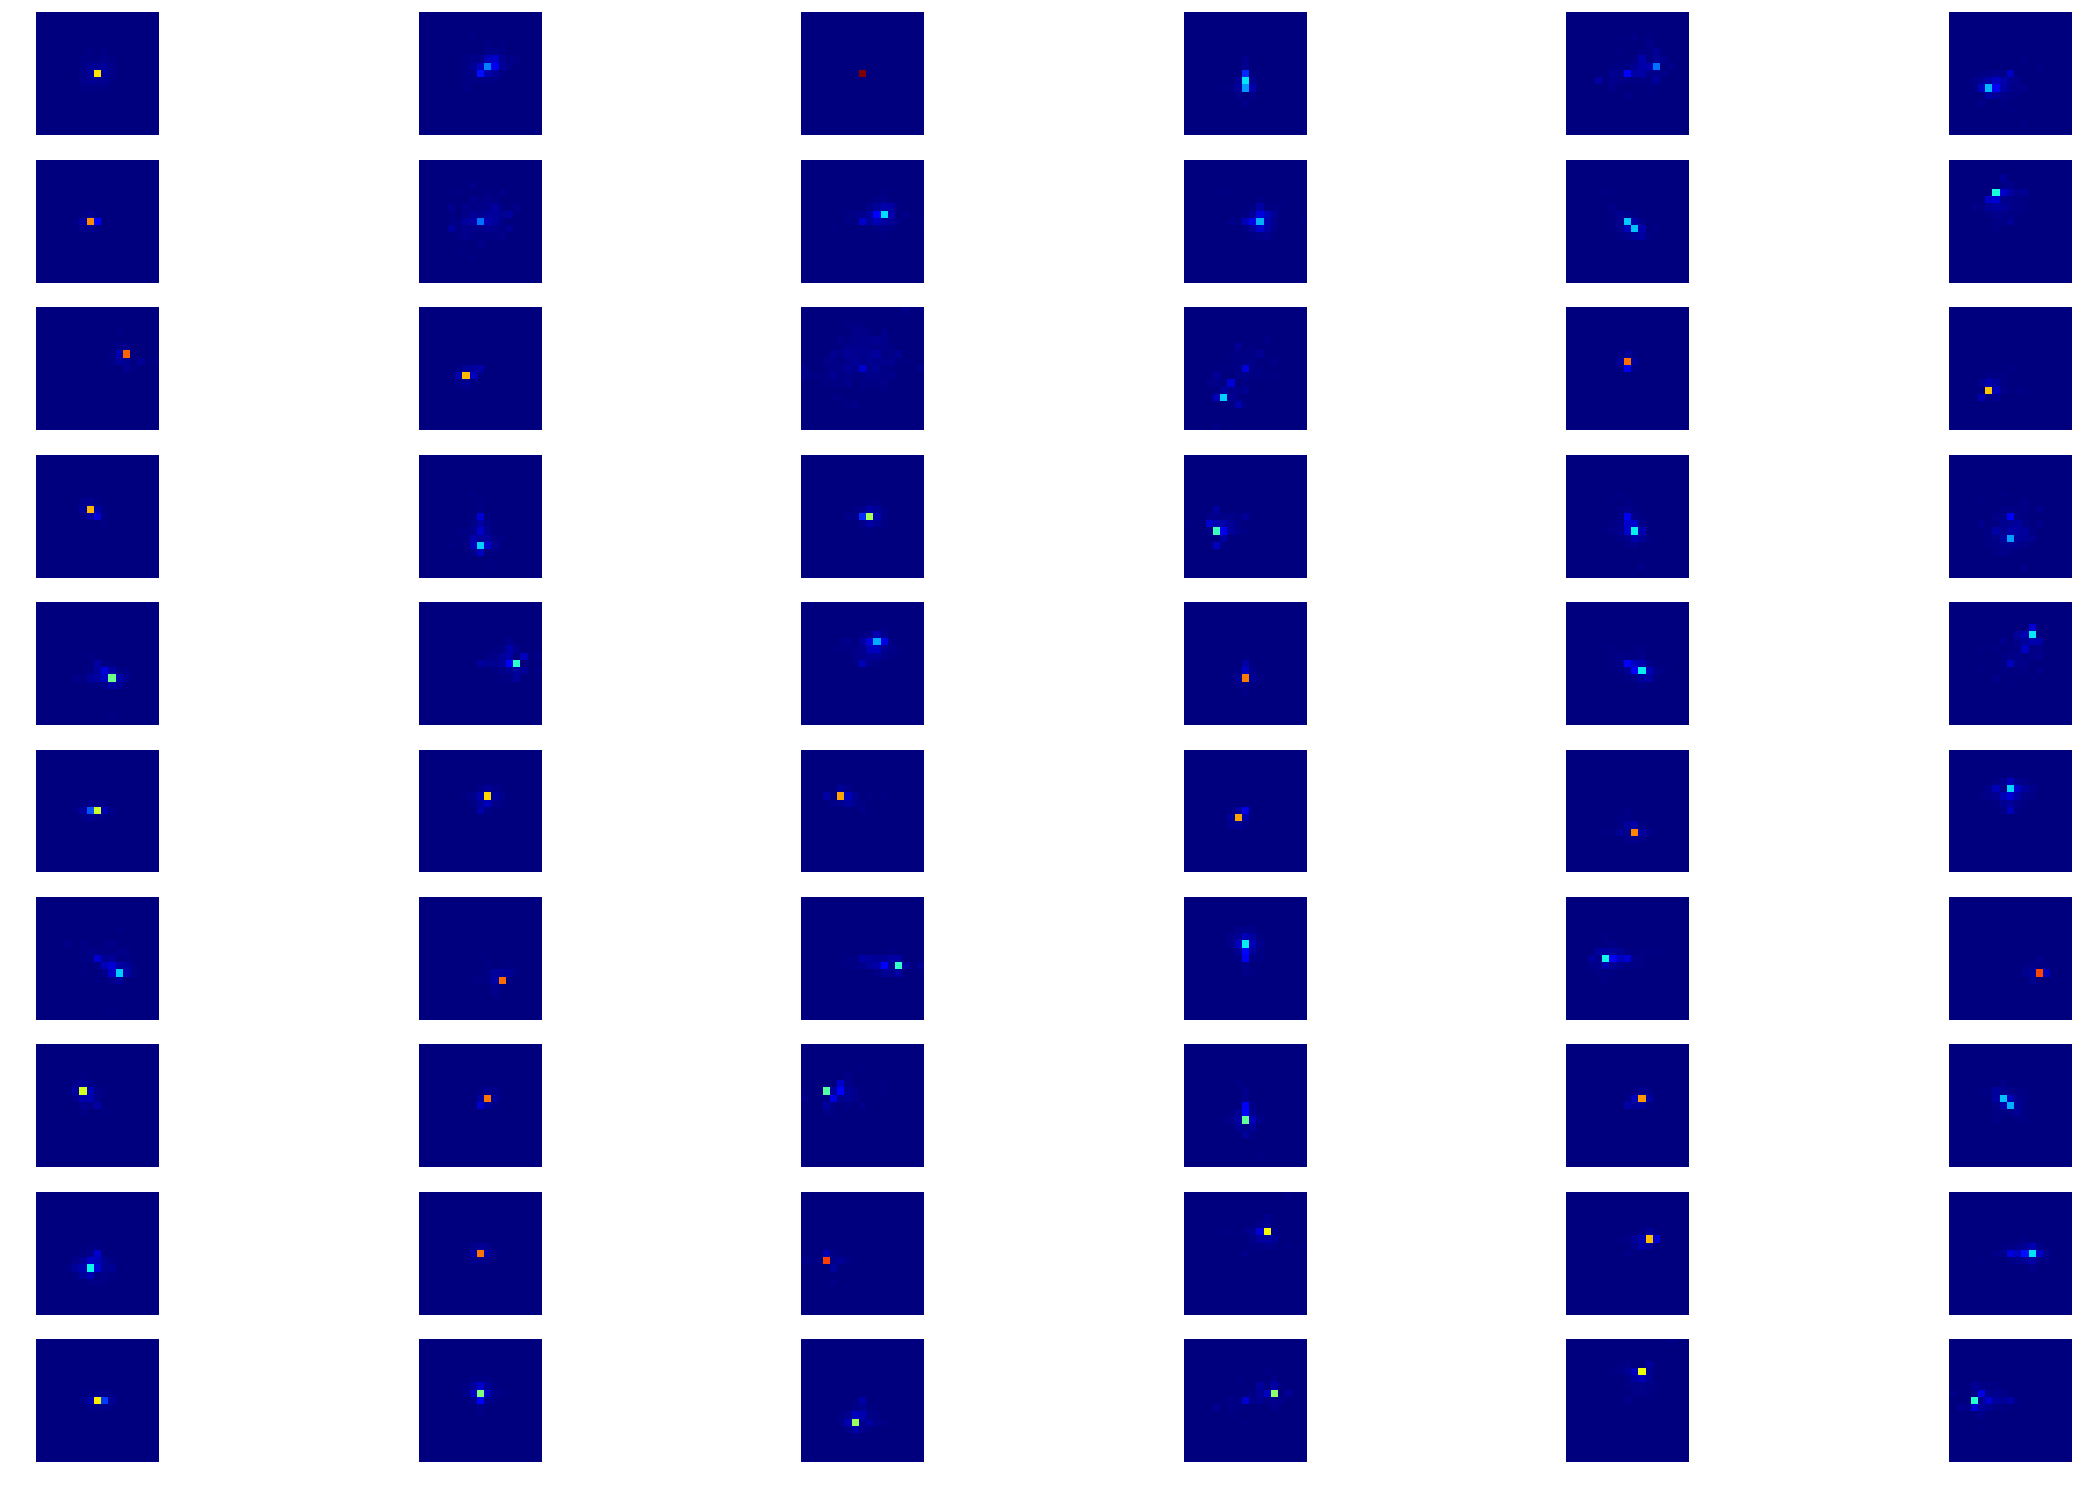

In [19]:
figWinNumHeight, figWinNumWidth, subwinCount = 10, 6, 1
plt.figure(figsize=(30,20), dpi=96, facecolor='w', edgecolor='k') # figsize -- inch-by-inch0
plt.clf()

for idx in range(figWinNumHeight*figWinNumWidth):
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    plt.imshow(kcenters[idx,:,:], cmap='jet')
    plt.clim(caxisMin, caxisMax)
    plt.axis('off')       


In [20]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

import numpy as np
import pylab


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 200 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y



#    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
#    print("Running example on 2,500 MNIST digits...")
#    X = np.loadtxt("mnist2500_X.txt")
#    labels = np.loadtxt("mnist2500_labels.txt")
#    Y = tsne(X, 2, 50, 20.0)
#    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
#    pylab.show()+

In [21]:
kmeansCenters = kmeans.cluster_centers_.reshape(KK,-1)
Yorg = tsne(kmeansCenters, 2, 289, 20.0)
Y = Yorg
Y[:,0] = Y[:,0]/max(abs(Y[:,0]))*20
Y[:,1] = Y[:,1]/max(abs(Y[:,1]))*20

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 200...
Mean value of sigma: 0.216265
Iteration 200: error is 1.700830
Iteration 400: error is 1.061780
Iteration 600: error is 0.991188
Iteration 800: error is 0.955955
Iteration 1000: error is 0.915193


In [22]:
from matplotlib import offsetbox
import matplotlib as mpl
def plot_components(data, coordY, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    caxisMax, caxisMin = images.max(), images.min()
    norm = mpl.colors.Normalize(vmin=caxisMin, vmax=caxisMax)
    
    #proj = model.fit_transform(data)
    #ax.plot(proj[:, 0], proj[:, 1], '.k')
    ax.plot(coordY[:, 0], coordY[:, 1], '.k')    
    if images is not None:
        min_dist_2 = (thumb_frac * max(coordY.max(0) - coordY.min(0))) ** 2
        shown_images = np.array([2 * coordY.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((coordY[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, coordY[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], zoom=1.5, 
                                      cmap=cmap, norm=norm,),
                                      coordY[i], pad=0.2)
            ax.add_artist(imagebox)

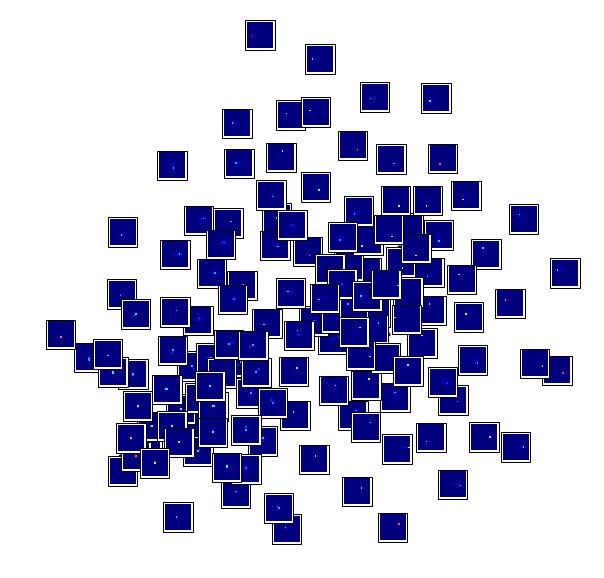

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))

# Y = np.flip(Y,axis=1)
plot_components(kmeansCenters, Y, # np.flip(Y,axis=1)
                images=kmeansCenters.reshape((-1,17,17)), 
                thumb_frac=0.03, cmap='jet')
plt.axis('off')
plt.savefig(path.join(save_dir,'filters_t-sne.png'.format(idx)),bbox_inches='tight',transparent=True)
plt.savefig(path.join(save_dir,'filters_t-sne.eps'.format(idx)),bbox_inches='tight',transparent=True)

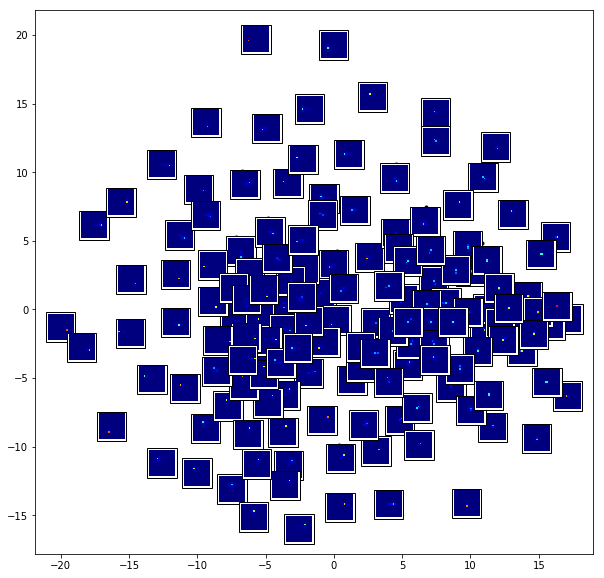

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(kmeansCenters, Y,
                images=kmeansCenters.reshape((-1,17,17)), 
                thumb_frac=0.03, cmap='jet')

(200, 289)
(200, 289) (154100, 289)
(154100,)


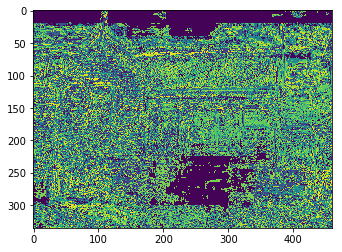

199 0
(335, 460)
(154100, 1)
(335, 460, 2)


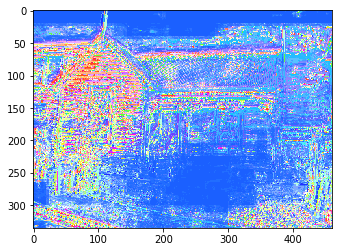

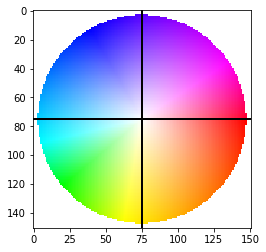

In [35]:
print(kmeans.cluster_centers_.shape)

X = XXX[0] # filterFlowMap
hhh, www = X.shape[1], X.shape[2]

X = X.reshape((kernel_size**2,-1))
X = np.transpose(X)
print(kmeans.cluster_centers_.shape, X.shape)

imglabel = kmeans.predict(X)
print(imglabel.shape)

indicatorMat = imglabel.reshape((hhh,www)) #= np.zeros((1,X.shape[1]),dtype=np.float32)
#indicatorMat = indicatorMat*1.0 / indicatorMat.max()
plt.figure()
plt.imshow(indicatorMat*1.0)
plt.show()

print(indicatorMat.max(), indicatorMat.min())
print(indicatorMat.shape)
B = indicatorMat.reshape(-1,1)
print(B.shape)
C = np.zeros((B.shape[0],2))
for i in range(B.shape[0]):
    C[i,:] = Y[B[i]]
C = C.reshape((hhh,www,2)) / abs(C).max() 
print(C.shape)




objDemoShowFlow = DemoShowFlow() # height=int(Y.max()), width=int(Y.max())
objDemoShowFlow.height = Y.max()
objDemoShowFlow.width = Y.max()

#UV = objDemoShowFlow.filterFlow2UV(flowVis).detach().numpy()
#UV = UV/np.ceil(kernel_size/2)
#UV = UV/UV.max()
flowVis = objDemoShowFlow.computeColor(C[:,:,0], C[:,:,1])
flowVis = flowVis / 255 # flowVis.max()
plt.imshow(flowVis)

plt.figure()
plt.imshow(objDemoShowFlow.FlowColorChart)
plt.show()
misc.imsave(os.path.join(save_dir, 'colorchar.png'.format(idx)), objDemoShowFlow.FlowColorChart*255, format='png')

sample01
sample02
sample03
sample04
sample05
sample06
sample07
sample08
sample09
sample10
sample11
sample12
sample13
sample14
sample15
sample16
sample17
sample18
sample19
sample20


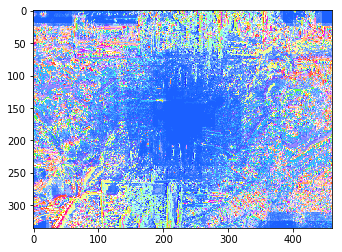

In [36]:
sampleIdx = 0
for X in XXX: # filterFlowMap
    sampleIdx += 1
    print('sample{:02d}'.format(sampleIdx))
    hhh, www = X.shape[1], X.shape[2]
    X = X.reshape((kernel_size**2,-1))
    X = np.transpose(X)
    imglabel = kmeans.predict(X)
    indicatorMat = imglabel.reshape((hhh,www)) 
    B = indicatorMat.reshape(-1,1)
    C = np.zeros((B.shape[0],2))
    for i in range(B.shape[0]):
        C[i,:] = Y[B[i]]
    C = C.reshape((hhh,www,2)) / abs(C).max() 
    
    objDemoShowFlow = DemoShowFlow() # height=int(Y.max()), width=int(Y.max())
    objDemoShowFlow.height = Y.max()
    objDemoShowFlow.width = Y.max()

    #UV = objDemoShowFlow.filterFlow2UV(flowVis).detach().numpy()
    #UV = UV/np.ceil(kernel_size/2)
    #UV = UV/UV.max()
    flowVis = objDemoShowFlow.computeColor(C[:,:,0], C[:,:,1])
    flowVis = flowVis / 255 # flowVis.max()
    plt.imshow(flowVis)
    misc.imsave(os.path.join(save_dir, '{:02d}_tSNE_visual.png'.format(sampleIdx)), flowVis*255, format='png')